# CSCI4022 Final Project

## 2 May 2023

#### Author: Jack Higgins

**Project Proposal**

I am from the Seattle area and I spend a lot of time in the area because most of my family lives there. It would be interesting to see where crime is located by longitude and latitude. My project will focus on finding what places to avoid within the city of Seattle. Clustering data by location to see where the most dangerous parts of the city would solve this.
The data set I am using has over a million rows with each row being a crime that has been committed since 2008. Each row has 17 data columns consisting of locational data, offense data, and date/time of the crime. The data is provided by the Seattle Police Department, so it has validity and is released on a .gov website.


I plan to cluster using K-means, trying different values of K until the clusters appear appropriate. I can use Euclidean distance with the latitude or longitude. However, technically Euclidean distance is not supposed to be used with latitude and longitude because of the curvature of the earth. Another option for a distance metric using an API to find the walking/driving distance between two locations. Additionally, Seattle is on a coast so straight line distance is not a good measure. I would also like to find areas of Seattle that have higher homeless populations and higher levels of poverty. I would hypothesize that the areas where crime is common correspond with higher levels of poverty.

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.stats as stats
import random
import seaborn as sns

### Data set cleaning

Get rid of errant longitude, latitude values

In [2]:
raw=pd.read_csv("../data/Crime_Data.csv")
df = raw[["Offense Start DateTime","100 Block Address", "Longitude", "Latitude"]]

DF pre cuts length:  1047141
DF post cuts length:  1002202
2020 df length 71401


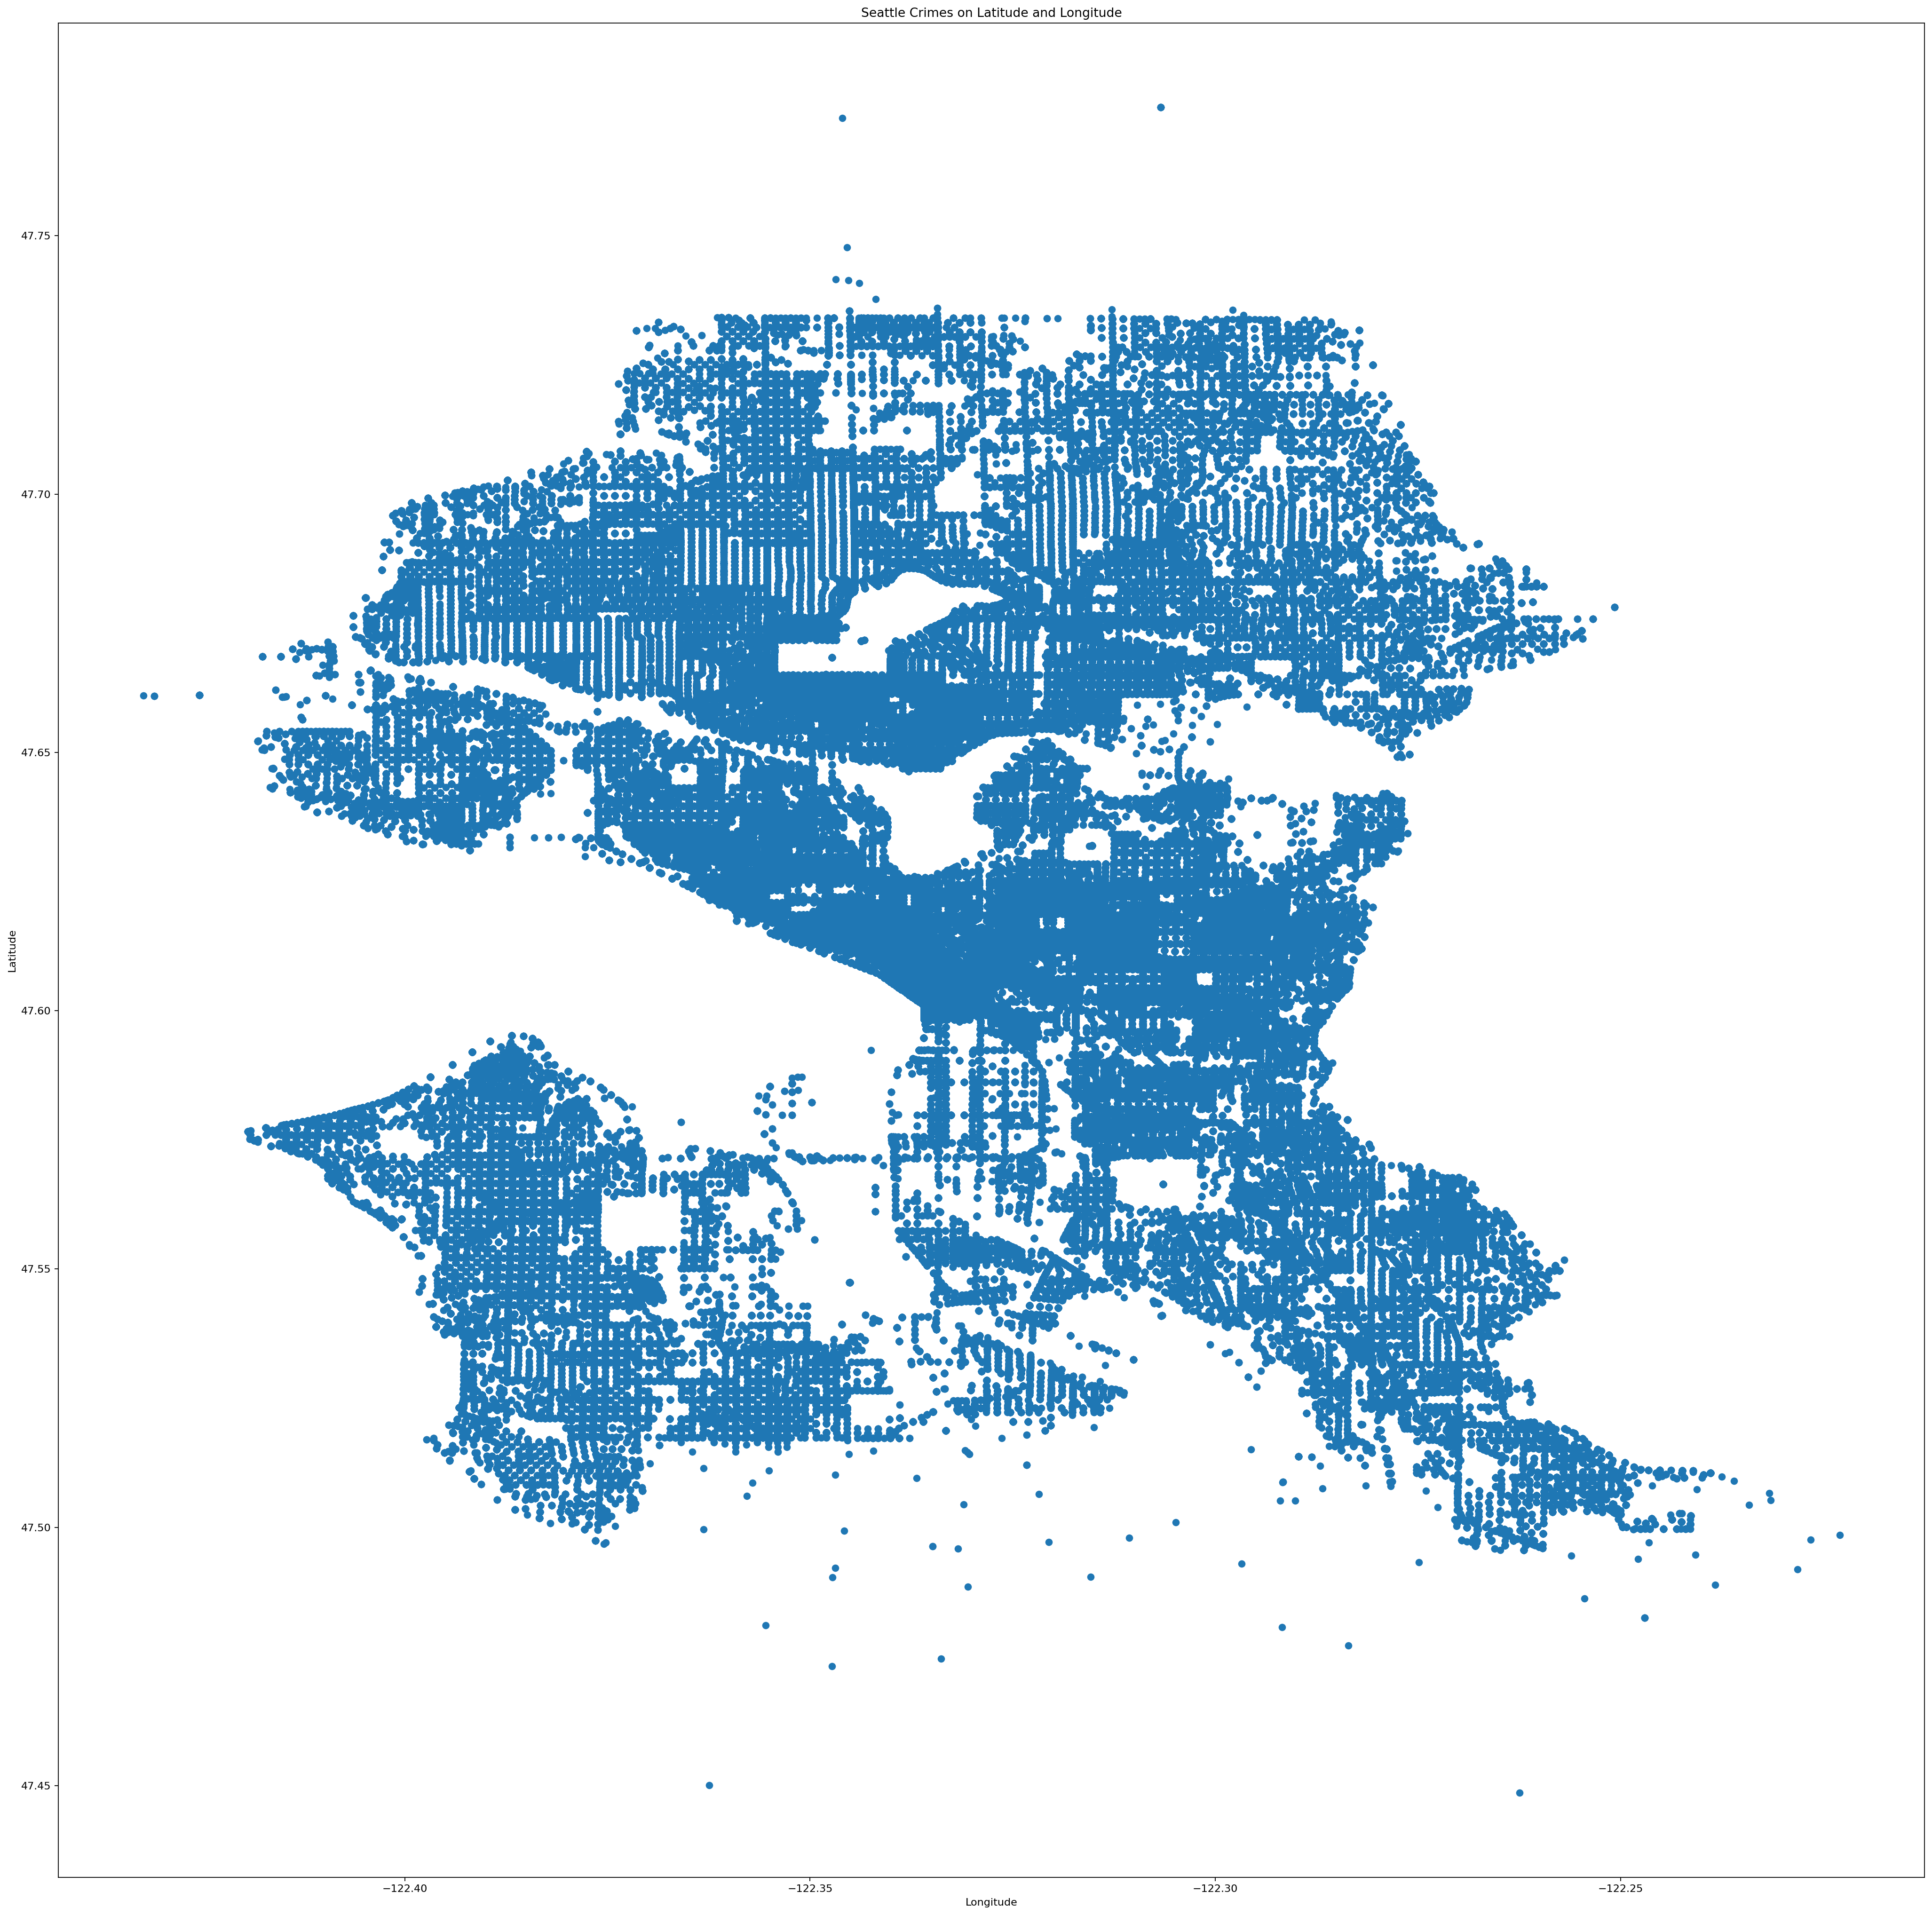

In [3]:
raw=pd.read_csv("../data/Crime_Data.csv")
df = raw[["Offense Start DateTime","Longitude", "Latitude"]] #"Offense Start DateTime","100 Block Address", 
# df.head()
# print(df.iloc[0]["Latitude"])
print("DF pre cuts length: ", len(df))
df = df[df["Longitude"] < -120.0]
df = df[df["Latitude"] > 46.0]

df = df[df["Longitude"] > -123.0]
df = df[df["Latitude"] < 48.0]
print("DF post cuts length: ", len(df))

df_2020 = df[df["Offense Start DateTime"].str[6:10] == "2020"]
print("2020 df length",len(df_2020))
# df_2020.head()

df.head()
plt.figure(figsize=(32, 32), dpi=160)
plt.scatter(x=df['Longitude'], y=df['Latitude'])
plt.title("Seattle Crimes on Latitude and Longitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

![Seattle](img/Seattle.jpg)

Comparing the two we can see the shapes align because crimes mainly take place on land. Eliot bay, green lake, and lake union are all outlined by the lack of dots. 

Another thing that's potentially interesting is seperating crime by offense.

In [4]:
# crime_groups = np.unique(raw["Offense Parent Group"])
crime_against = np.unique(raw["Crime Against Category"])
# print(crime_groups)

# for g in crime_groups:
#     print(g, ":", len(raw[raw["Offense Parent Group"] == g]))
for g in crime_against:
    print(g, ":", len(raw[raw["Crime Against Category"] == g]))

NOT_A_CRIME : 33
PERSON : 159265
PROPERTY : 780585
SOCIETY : 107258


### GMM clustering on Latitude/Longitude

Because the data set is a million values I will randomly sample increasing amounts of points. I used the class implementation of GMM with some minor differences.

In [5]:
# Used GMM code from hw because mine was too slow
def GMM(dat, k):
    
    #Comments will reference slides 26-31 from Feb 9:
    
    """Define the variables we will use in the Algorithm"""
    #This represents W_m (weights/likelihood of each component) (slide 26)
    p_class=np.zeros(k)
    
    #This represents μ_m (mean values of each component) (slide 26)
    means=np.zeros((k,2))
    
    #This represents Σ_m (covariance matrix) (slide 26)
    covars=np.zeros((k,2,2))
    
    #This represets p̃_mi (slide 27)
    p_data_given_class=np.zeros((len(dat),k))

    #This is just used at the end to compute mean dist
    mean_dist=np.array(0)
    
    #initializations of initial points (used to set the initial menas lower down)
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    
    """Initialize means, covs, p_classes"""
    #Initialize the covariance matrix, the means, and the p_class for each of k components (dims)
    for dim in range(k):
        #Set the cov matrix of each component to the cov of the entire dataset (slide 26)
        covars[dim,:,:]=np.cov(np.transpose(dat))

        #Set initial means to initial chosen data points (slide 26)
        means[dim,:]=dat.iloc[init_idx[dim]]
        
        #Give each component equal weighting / likelihood to start (slide 26)
        p_class[dim]=1/k
        
    
    #Now we start our for loop, where-in we'll alernate between: (1) Expecation Step and (2) Maximization Step
    for step in range(50):  
        
        """Expectation Step (Slide 27)"""
        #Bayes stuff: pdfs then pdf*mixtures, then normalize
        
        #For each class (component), compute prob data given class slide 27)
        for dim in range(k):
            #Use pdf to get prob of each data point given component (dim) (slide 27)
            p_data_given_class[:,dim]=  np.array([stats.multivariate_normal.pdf(x=dat, mean=means[dim,:], cov=covars[dim,:,:])])
            #What we have now is P(x_i | cluster = m). We still need to multiply by P(cluster = m)
            
        #Multiply by p_class (slide 27)
        p_class_given_data=p_data_given_class*p_class

        #Now consolidate into probabilities using 1/α_i (slide 27)
        sums=np.sum(p_class_given_data, axis=1)

        for dim in range(k):
            #For each class, divide by the sum to convert to probabilities (slide 27)
            #p_class_given_data now represents p̂_mi
            p_class_given_data[:,dim]=p_class_given_data[:,dim]*(1/sums)
            
        #Now we have completed everything in the Expectation step (slide 27). We'll move on to the maximization step
        
        """Maximization Step (Slide 29-30)"""
        #We'll count the number of points in each component (will be fractional, not whole #)
        #n_class represents n̂_m (Slide 30)
        n_class = np.sum(p_class_given_data, axis=0)

        #Now, we re-compute p_class (which represents W_m, or the weight/likelihood of each class)
        #(See first bullet pt on slide 30)
        p_class=n_class/len(dat)

        #Now we need to do the mean and covariance updates (slide 30)
        for dim in range(k):
            #To compute new means within each class/component (slide 30 bullet pt. 2)
            #1. Sum across: (p_class_given_data * data) = (p̂_mi * x_i)
            #2. Divide by n_class (n̂_m)
            means[dim,0]=np.sum(p_class_given_data[:,dim]*dat.iloc[:,0])*(1/n_class[dim])
            means[dim,1]=np.sum(p_class_given_data[:,dim]*dat.iloc[:,1])*(1/n_class[dim])
            
            
            #Now we update the variance/covariance Σ_m by weighted sample covariance (slide 30 bullet pt. 3)
            
            #Make a copy of the data, then subtract the new means
            X_new=dat.copy()
            X_new.iloc[:,0]=X_new.iloc[:,0]-means[dim,0]
            X_new.iloc[:,1]=X_new.iloc[:,1]-means[dim,1]
                        
            #We can compute the covar matrix for each component as below (slide 30 bullet pt. 3):
            #1. First we'll take the transpose of our new "centered" data (X_new)
            #2. Then we multiply that by our p_class_given_data (p̂_mi)
            #3. Next we do a matrix multiplication between our result from step 2 and X_new (mean centered data)
            #4. Last, we divide by n_class (n̂_m)
            
            
            covars[dim,:,:]=np.matmul((np.asarray(X_new).T)*(p_class_given_data[:,dim]),X_new)/(n_class[dim])
    #Once we're done with our for loop, we compute the mean dist (This formula is given below in Part B):
    mean_dist=0
    for pt in range(len(dat)):
        for dim in range(k):
            
            mean_dist+=np.sqrt(np.sum((means[dim,:]-np.array(dat.iloc[pt]))**2)*p_class_given_data[pt,dim])
    mean_dist=mean_dist/(len(dat)*k)
    return p_class_given_data, means, covars, p_class, mean_dist

In [6]:
pmi1, mu1, sig1, p1, d1 = GMM(df_2020[["Latitude", "Longitude"]],1)

In [7]:
pmi2, mu2, sig2, p2, d2 = GMM(df_2020[["Latitude", "Longitude"]],2)

In [8]:
pmi3, mu3, sig3, p3, d3 = GMM(df_2020[["Latitude", "Longitude"]],3) 

In [9]:
pmi4, mu4, sig4, p4, d4 = GMM(df_2020[["Latitude", "Longitude"]],4)

In [10]:
pmi5, mu5, sig5, p5, d5 = GMM(df_2020[["Latitude", "Longitude"]],5)

In [11]:
pmi7, mu7, sig7, p7, d7 = GMM(df_2020[["Latitude", "Longitude"]],7)

In [12]:
pmi10, mu10, sig10, p10, d10 = GMM(df_2020[["Latitude", "Longitude"]],10)

In [13]:
pmi30, mu30, sig30, p30, d30 = GMM(df_2020[["Latitude", "Longitude"]],30)

In [14]:
def printGraph(pmi, mu, sig, p, d):
    print("Means:", mu)
    print("PMI:", pmi)
    plt.figure(figsize=(32, 32), dpi=160)
    plt.scatter(df_2020['Longitude'], df_2020['Latitude'], c=pmi[:,0])
    plt.title("2020 Seattle Crimes on Latitude and Longitude")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

Means: [[  47.62244727 -122.32929655]
 [  47.53581583 -122.27594248]
 [  47.54628945 -122.32684518]
 [  47.66422013 -122.33814631]
 [  47.71004021 -122.32169881]
 [  47.52286121 -122.36234364]
 [  47.6628326  -122.36644586]
 [  47.63025355 -122.31988431]
 [  47.67554664 -122.31692297]
 [  47.60717401 -122.30778198]
 [  47.62427632 -122.31991903]
 [  47.56225775 -122.32801641]
 [  47.60036708 -122.30367967]
 [  47.62682862 -122.34552134]
 [  47.72189155 -122.29386019]
 [  47.625053   -122.31879055]
 [  47.67051883 -122.37772212]
 [  47.57142411 -122.29265013]
 [  47.60961177 -122.30276882]
 [  47.65321632 -122.33785128]
 [  47.61450533 -122.31095651]
 [  47.55825095 -122.38081091]
 [  47.66268209 -122.31353452]
 [  47.59596921 -122.31359522]
 [  47.61049113 -122.34048252]
 [  47.70462701 -122.34870162]
 [  47.67361191 -122.38133081]
 [  47.61299657 -122.32327755]
 [  47.67696202 -122.28720432]
 [  47.61943006 -122.31550647]]
PMI: [[1.23197379e-003 5.31493045e-019 6.95977467e-177 ... 2.3

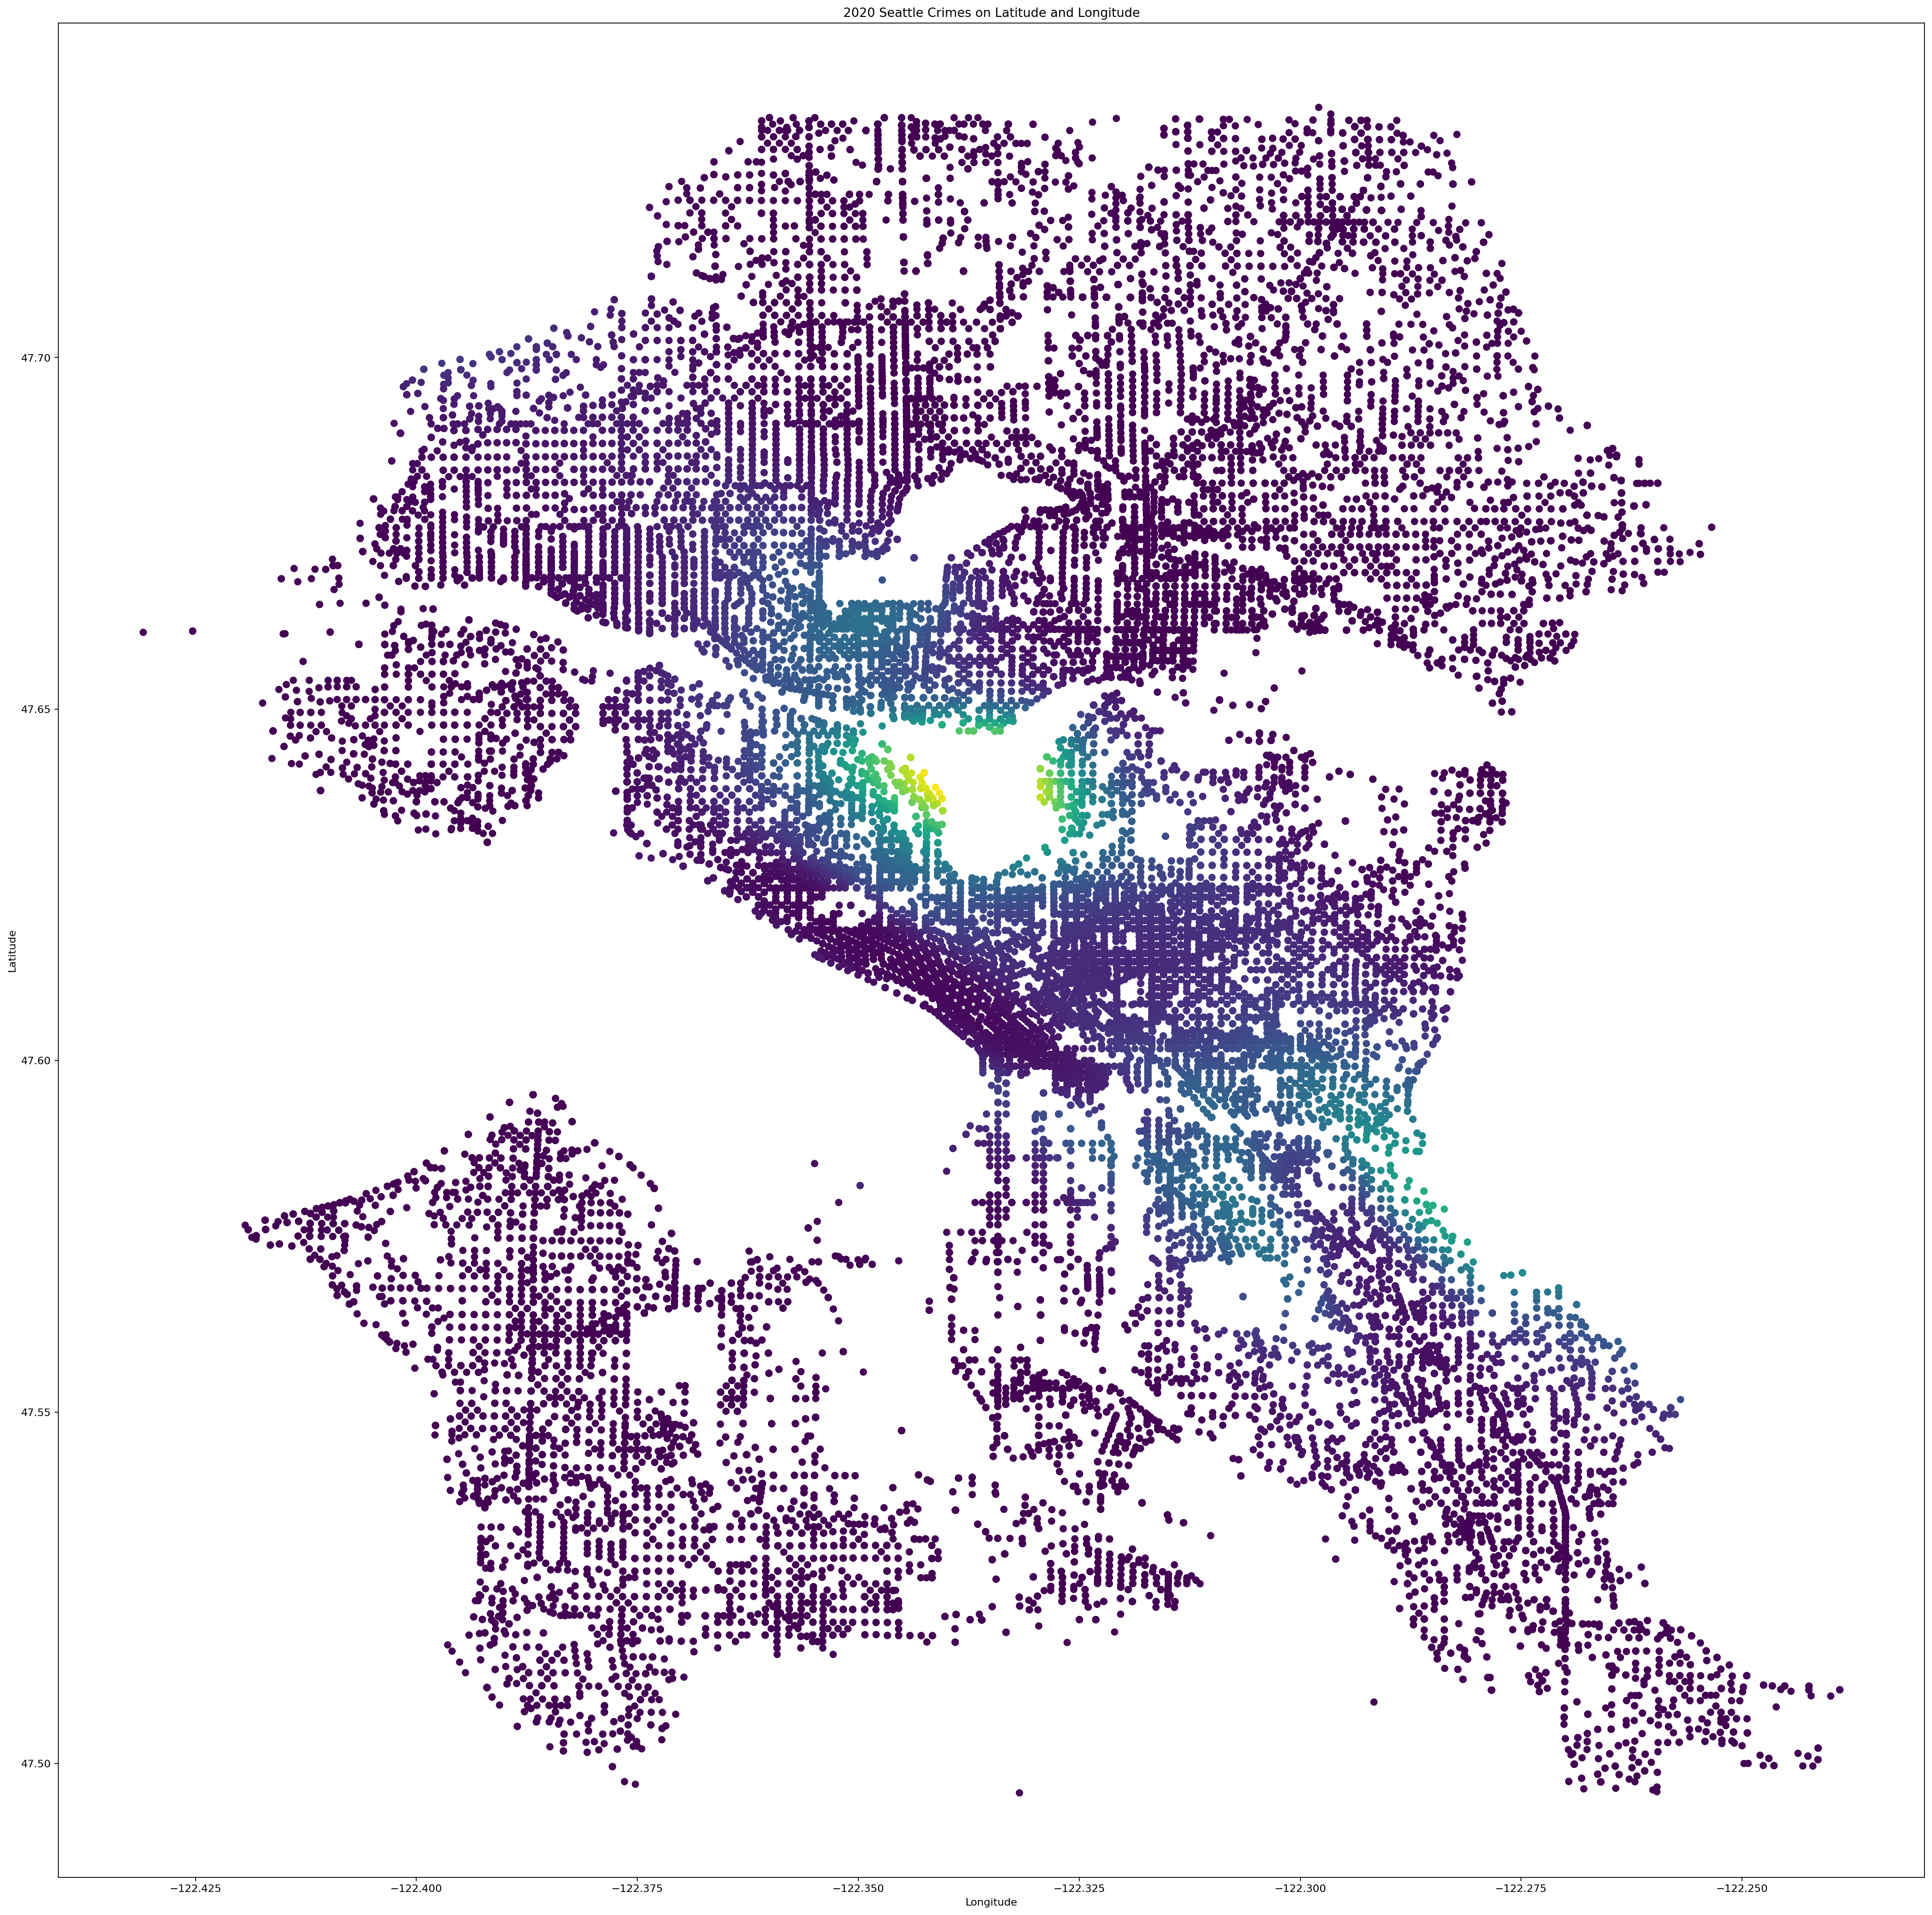

In [15]:
printGraph(pmi30, mu30, sig30, p30, d30)

### K-Means Clustering on 2020 Seattle Crime

Due to GMM's not giving me clustering that I found particularly interesting I thought I would try K-means and compare the results of the two.

In [16]:
def dist(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

In [17]:
def distance(p1,p2):
    return np.sqrt(np.sum((p1-p2)**2))

# Used Kmeans code from HW - mine was too slow
def kmeans(df, k, tol): 
    """
    Usage: input 
        df=data frame, 
        k=# of clusters
        tol=tolerance for L_2 convergance check on centroids
    """    
    #random centroids from data
    clocs=np.random.choice(range(len(df)), size=k)
    centroids = np.array([df.iloc[clocs[ki]] for ki in range(k)])
    
    #Initialize objects for points-cluster dists, cluster assignments.
    dists=np.zeros((k,len(df)))
    clusters = np.array([-1]*len(df))
    
    #index/convergence trackers
    ii=0
    Done=False
    while not Done: #50+ steps is fine; or a tolerance/change check is faster.
        #convergence checks
        centroidso=centroids.copy()
        ii+=1
        if ii==50: 
            Done==True
            print('No convergence in 50 steps')
        for ji in range(k): #for ji'th cluster, compute its distance to all points.
            dists[ji,:]=df.apply(lambda x: distance(x, centroids[ji]), axis=1)

        clusters=dists.argmin(axis=0)
        
        for ji in range(k): #for ji'th cluster, compute its centroid
            centroids[ji,:]=np.sum(df.loc[clusters==ji])/np.sum(clusters==ji)

        #convergence checks
        if distance(centroids, centroidso)<tol: 
            print('Done at iteration',ii, 'with change of', distance(centroids, centroidso))
            Done=True
    meanerror=np.sum(dists.min(axis=0)**2)/len(df) #we already had the info needed saved!
    return centroids, clusters, meanerror

In [18]:
ctr2, clu2, mnr2 = kmeans(df_2020[["Latitude", "Longitude"]], 2, 0.025) 

Done at iteration 2 with change of 0.002278328956181126


In [19]:
ctr7, clu7, mnr7 = kmeans(df_2020[["Latitude", "Longitude"]], 7, 0.1)

Done at iteration 1 with change of 0.03699628188147162


In [20]:
ctr20, clu20, mnr20 = kmeans(df_2020[["Latitude", "Longitude"]], 20, 0.1)

Done at iteration 1 with change of 0.0489877432856552


In [ ]:
ctr30, clu30, mnr30 = kmeans(df_2020[["Latitude", "Longitude"]], 30, 0.025)

In [ ]:
def printKmean(df, clusters, title):
    # used code from hw
    dat=df.copy()
    dat['Cluster'] = clusters
    sns.set(rc={'figure.figsize':(12,12)})
    ax = sns.scatterplot(data=dat, x='Latitude',y='Longitude',hue='Cluster',palette="icefire")
    plt.show()
def printCentroids(centroids, title):
    print(centroids)
    lat=[]
    lng=[]
    for i in centroids:
        lat.append(i[0])
        lng.append(i[1])
    plt.scatter(lat,lng)

In [ ]:
printKmean(df_2020,clu30, "Seattle Crime")

In [ ]:
printCentroids(ctr30, "K-means Centroids")

In [ ]:
printCentroids(mu30, "GMM Centroids")

![Income Map](img/seattle_income_small.jpg)

What is an appropriate 'k' value when the data set is 71,000 values? My computer cannot handle too many clusters and I had to lower the tolerance to get it to run at all.